# Abstract:
 Build a Predictive model to classify Churn user based on given features.

# Index of notebook:

1. Data Processing
2. Exploratory Data Analysis
3. Modeling
    - 3.1. Baseline Models
    - 3.2. Handling imbalanced data    
    - 3.3. Model Tuning
    - 3.4. Baseline Models Performance
4. Model Statistics
    - 4.1. Statistics by class
    - 4.2. Confusion matrix
5. Feature Importance
6. Conclusion


## 1. Data Processing:

In [1]:
import pandas as pd
import numpy as np
from datetime import date

# sklearn modules for data preprocessing:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

#Model Selection:
from sklearn import naive_bayes, ensemble, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#sklearn modules for Model Evaluation & Improvement:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection

from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve


#Standard libraries for data visualization:
import seaborn as sn
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline


import random
random.seed(20)

In [2]:
features_data = pd.read_csv("features_data.csv")
equity_value_data = pd.read_csv("equity_value_data.csv")

In [3]:
'''Function to extract date in %%y-%%m-%%d'''
def todate(timestamp):
    
    s = timestamp.split("-")
    year = s[0]
    month = s[1]
    date = s[2] 
    date = year+'-'+month+'-'+date[0]+date[1]
    return date


'''Function to get the difference between the dates'''
def date_diff(date_,date1_):
    
    d = date_.split("-")
    d_ = date1_.split("-")
    
    d0 = date(int(d[0]), int(d[1]), int(d[2]))
    d1 = date(int(d_[0]), int(d_[1]), int(d_[2]))
    delta = d1 - d0
    return delta.days


In [4]:
'''To create date column in equity_value_data'''
equity_value_data['date'] = equity_value_data['timestamp'].apply(todate)
equity_value_data.head()

,timestamp,close_equity,user_id,date
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-16
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-17
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-18
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-21
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-22


In [5]:
%%time

##############################################################################################################
#####################  Calculating Churn user by applying 28 consecutive days condition  #####################
##############################################################################################################

cnt = 0

#To save Churn users
churn_user = []

for i in range(len(equity_value_data['user_id'])-1):
    
    if equity_value_data['user_id'][i] == equity_value_data['user_id'][i+1]:
        
        days = date_diff(equity_value_data['date'][i],equity_value_data['date'][i+1])
        
        if days >=28 and (equity_value_data['user_id'][i] not in churn_user):
            
            churn_user.append(equity_value_data['user_id'][i])
            cnt += 1

            
Total_User = len(features_data['user_id'])

print("Total user: ", Total_User)
print("Total churn user: ", cnt)
print("Percentage: ",round(cnt / Total_User * 100, 2),"%")

Total user:  5584
Total churn user:  279
Percentage:  5.0 %
Wall time: 18 s


In [6]:
'''Adding Churn feature in the features_data'''

features_data['Churn'] = 0
for i in range(len(features_data['user_id'])):
    if features_data['user_id'][i] not in churn_user:
        features_data['Churn'][i] = 0
    else:
        features_data['Churn'][i] = 1     

C:\Users\khist\AppData\Local\Temp/ipykernel_9692/2416584116.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_data['Churn'][i] = 0
C:\Users\khist\AppData\Local\Temp/ipykernel_9692/2416584116.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_data['Churn'][i] = 1


In [7]:
features_data.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,Churn
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0


## 2. Exploratory Data Analysis:

In [8]:
data = features_data.copy()

In [9]:
data.columns

Index(['risk_tolerance', 'investment_experience', 'liquidity_needs',
       'platform', 'time_spent', 'instrument_type_first_traded',
       'first_deposit_amount', 'time_horizon', 'user_id', 'Churn'],
      dtype='object')

In [10]:
data.drop('user_id',axis = 1, inplace= True)

In [11]:
data.isna().any()

risk_tolerance                  False
investment_experience           False
liquidity_needs                 False
platform                        False
time_spent                      False
instrument_type_first_traded    False
first_deposit_amount            False
time_horizon                    False
Churn                           False
dtype: bool

In [12]:
data.describe()

,time_spent,first_deposit_amount,Churn
count,5584.000000,5584.000000,5584.000000
mean,34.509706,633.566805,0.049964
std,155.080551,2118.323263,0.217890
min,0.000000,0.000000,0.000000
25%,2.848908,50.000000,0.000000
50%,13.474708,100.000000,0.000000
75%,33.823829,500.000000,0.000000
max,8788.329450,50000.000000,1.000000


In [13]:
data.dtypes

risk_tolerance                   object
investment_experience            object
liquidity_needs                  object
platform                         object
time_spent                      float64
instrument_type_first_traded     object
first_deposit_amount            float64
time_horizon                     object
Churn                             int64
dtype: object

In [14]:
print(data["Churn"].value_counts())

0    5305
1     279
Name: Churn, dtype: int64


 - Data is Highly Imbalanced hence we need to try different oversampling techniques in the modeling section.

In [15]:
data.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,Churn
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,0


In [16]:
df = pd.get_dummies(data, prefix=['Tolerance_','Exp_',"liq_",'pltform_','first_traded','time_'])

In [17]:
df.head()

,time_spent,first_deposit_amount,Churn,Tolerance__high_risk_tolerance,Tolerance__low_risk_tolerance,Tolerance__med_risk_tolerance,Exp__extensive_investment_exp,Exp__good_investment_exp,Exp__limited_investment_exp,Exp__no_investment_exp,...,first_traded_lp,first_traded_mlp,first_traded_reit,first_traded_rlt,first_traded_stock,first_traded_tracking,first_traded_wrt,time__long_time_horizon,time__med_time_horizon,time__short_time_horizon
0,33.129417,40.0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,16.573517,200.0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,10.008367,25.0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,1.031633,100.0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,8.187250,20.0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


### Correlation:

In [18]:
'''Top highly correlated features with Churn data'''

df[df.columns[1:-1]].apply(lambda x: x.corr(df['Churn'])).sort_values(ascending=False)

Churn                               1.000000
Tolerance__low_risk_tolerance       0.061152
Tolerance__med_risk_tolerance       0.040776
pltform__both                       0.033727
first_traded_wrt                    0.018462
first_traded_lp                     0.013045
liq__not_important_liq_need         0.012174
liq__somewhat_important_liq_need    0.009456
Exp__no_investment_exp              0.007504
pltform__Android                    0.006645
first_traded_0                      0.005977
Exp__limited_investment_exp         0.005263
first_traded_mlp                    0.002097
first_traded_stock                  0.001976
first_traded_cef                    0.000010
first_traded_etp                   -0.000443
first_traded_tracking              -0.003069
first_traded_adr                   -0.003756
Exp__extensive_investment_exp      -0.005656
time__long_time_horizon            -0.006274
first_traded_rlt                   -0.009214
Exp__good_investment_exp           -0.013607
first_trad

__Top 3 Highly correlated features are:__
   1. Tolerance__high_risk_tolerance
   2. Tolerance__low_risk_tolerance
   3. Tolerance__med_risk_tolerance
   
- __risk_tolerance, platform, first_deposit_amount__ are the top 3 categorical features from the original dataset.
   
- __+/-__ is just an direction of correlation hence we can consider absolute value of a pearson correlation of a feature.


## 3. Modeling:

In [19]:
### Train-Test Split:

Y = df["Churn"]
X = df.drop(columns="Churn")

X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y, test_size = 0.2,random_state=20)


### Scaling:

sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

### 3.1 Baseline Models:

In [20]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [21]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0, class_weight='balanced')))
models.append(('SVC', SVC(kernel = 'linear', random_state = 0)))
models.append(('Kernel SVM', SVC(kernel = 'rbf', random_state = 0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
models.append(('Gaussian NB', GaussianNB()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 0,class_weight='balanced')))

#Evaluating Model Results:
acc_results = []
auc_results = []

names = []
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean']
i = 0
model_results = pd.DataFrame(columns=col)


# Evaluate each model using k-fold cross-validation:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)

    # Accuracy scoring:
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

    # Roc_auc scoring:
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    
    model_results.loc[i] = [name, round(cv_auc_results.mean()*100, 2), round(cv_auc_results.std()*100, 2), 
                            round(cv_acc_results.mean()*100, 2)]
    
    i += 1
print(model_results.sort_values(by=['ROC AUC Mean'], ascending=False))

                  Algorithm  ROC AUC Mean  ROC AUC STD  Accuracy Mean
6             Random Forest         56.25         6.32          93.75
0       Logistic Regression         55.90         4.69          62.21
4               Gaussian NB         54.63         6.05           7.86
3                       KNN         53.05         4.19          94.81
2                Kernel SVM         52.78         4.25          95.01
5  Decision Tree Classifier         49.57         3.50          90.19
1                       SVC         46.57         7.24          95.01


After looking at the above results, we can select the __Random Forest__
algorithm for further tuning & tesing on validation set of data. 

### 3.2 Handling imbalanced data:

#### 3.2.1 Oversampling using SMOTE:

In [22]:
sm = SMOTE(random_state=0)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X.shape} Shape of X after SMOTE: {X_sm.shape}''')
print(f'''Shape of X before SMOTE: {Y.shape} Shape of X after SMOTE: {y_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100


Shape of X before SMOTE: (5584, 29) Shape of X after SMOTE: (8488, 29)
Shape of X before SMOTE: (5584,) Shape of X after SMOTE: (8488,)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: Churn, dtype: float64

In [23]:
# Model
RF_cl = RandomForestClassifier(n_estimators = 72, criterion = 'entropy', class_weight={0:1,1:5} , random_state = 0)
RF_cl.fit(X_sm, y_sm)

# Predicting the Test set results 
y_pred = RF_cl.predict(X_test)

#Evaluate results
AUC = roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )


model_results = pd.DataFrame([['Random Forest', AUC, acc, prec, rec, f1]], columns = ['Model', 'AUC','Accuracy', 
                                                                                      'Precision', 'Recall', 'F1 Score'])
results = model_results.sort_values(["AUC","Precision", "Recall"], ascending = False)
print (results)

print(classification_report(y_test, y_pred))

           Model       AUC  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.521997  0.895255   0.082192  0.107143  0.093023
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1061
           1       0.08      0.11      0.09        56

    accuracy                           0.90      1117
   macro avg       0.52      0.52      0.52      1117
weighted avg       0.91      0.90      0.90      1117



#### 3.2.2 Undersampling using RandomUnderSampler:

In [24]:
rus = RandomUnderSampler() 

# resampling X, y
X_rus, y_rus = rus.fit_resample(X_train, y_train)


print(f'''Shape of X before SMOTE: {X_train.shape} Shape of X after SMOTE: {X_rus.shape}''')
print(f'''Shape of X before SMOTE: {y_train.shape} Shape of X after SMOTE: {y_rus.shape}''')

print('\nBalance of positive and negative classes (%):')
y_rus.value_counts(normalize=True) * 100

Shape of X before SMOTE: (4467, 29) Shape of X after SMOTE: (446, 29)
Shape of X before SMOTE: (4467,) Shape of X after SMOTE: (446,)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: Churn, dtype: float64

In [25]:
# Model
RF_cl = RandomForestClassifier(n_estimators = 72, criterion = 'entropy', class_weight={0:1,1:5} , random_state = 0)
RF_cl.fit(X_rus, y_rus)

# Predicting the Test set results 
y_pred2 = RF_cl.predict(X_test)

#Evaluate results
AUC = roc_auc_score(y_test, y_pred2)
acc = accuracy_score(y_test, y_pred2 )
prec = precision_score(y_test, y_pred2 )
rec = recall_score(y_test, y_pred2 )
f1 = f1_score(y_test, y_pred2 )


model_results = pd.DataFrame([['Random Forest', AUC, acc, prec, rec, f1]], columns = ['Model', 'AUC','Accuracy', 
                                                                                      'Precision', 'Recall', 'F1 Score'])

results = model_results.sort_values(["AUC","Precision", "Recall"], ascending = False)
print(results)
print(classification_report(y_test, y_pred))

           Model       AUC  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.547807  0.574754   0.060797  0.517857  0.108818
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1061
           1       0.08      0.11      0.09        56

    accuracy                           0.90      1117
   macro avg       0.52      0.52      0.52      1117
weighted avg       0.91      0.90      0.90      1117



- As you can see, __Undersampling & Oversampling__ didn't help in improving model performance. Hence we can keep the original data to tune the model.

### 3.3 Model Tuning: 

In [26]:
# Random Forest
    
RF_cl = RandomForestClassifier(n_estimators = 72, criterion = 'entropy', random_state = 0)
RF_cl.fit(X_train, y_train)

# Predicting the Test set results 
y_pred = RF_cl.predict(X_test)
print("Model Score on Test data: ",round(RF_cl.score(X_test,y_test),2))

Model Score on Test data:  0.95


In [27]:
cols = [i for i in X_train.columns]
importances = RF_cl.feature_importances_

forest_importances = pd.Series(importances, index=cols).sort_values(ascending= False)
forest_importances

time_spent                          0.413725
first_deposit_amount                0.274372
Exp__limited_investment_exp         0.023776
time__short_time_horizon            0.023106
Exp__no_investment_exp              0.022812
time__long_time_horizon             0.022767
Exp__good_investment_exp            0.019574
time__med_time_horizon              0.018009
pltform__iOS                        0.017824
liq__very_important_liq_need        0.017457
liq__somewhat_important_liq_need    0.016933
Tolerance__high_risk_tolerance      0.016677
pltform__both                       0.014590
first_traded_stock                  0.014492
Tolerance__med_risk_tolerance       0.013750
pltform__Android                    0.013512
Tolerance__low_risk_tolerance       0.011223
first_traded_etp                    0.010919
liq__not_important_liq_need         0.009167
first_traded_adr                    0.006474
Exp__extensive_investment_exp       0.004573
first_traded_mlp                    0.003320
first_trad

### 3.3.1 Hyper-Parameter Tuning using RandomSearchCV:

In [28]:
n_estimators = [50, 72, 80, 150, 250, 500]
max_features = ['auto','sqrt','log2']
max_depth = [10, 20, 30, 40, 50]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10, 15]


grid_param = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}


RF1_cl = RandomForestClassifier(criterion = 'entropy', random_state = 20)

clf = RandomizedSearchCV(estimator = RF1_cl,
                         param_distributions = grid_param,
                         n_iter=100,
                         cv=5,
                         verbose=1,
                         random_state=20,
                         n_jobs=-1)

search = clf.fit(X_train, y_train)

# Predicting the Test set results 
y_pred1 = search.predict(X_test)

# Best Parameters
search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 50,
 'min_samples_split': 15,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'max_depth': 50}

In [29]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1061
           1       0.00      0.00      0.00        56

    accuracy                           0.95      1117
   macro avg       0.47      0.50      0.49      1117
weighted avg       0.90      0.95      0.93      1117



C:\Users\khist\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\khist\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\khist\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.3.2 Feature selection:

In [30]:
# Important features
    
RF_cl = RandomForestClassifier(n_estimators = 72, criterion = 'entropy', random_state = 0)
RF_cl.fit(X_train, y_train)

cols = [i for i in X_train.columns]
importances = RF_cl.feature_importances_

forest_importances = pd.Series(importances, index=cols).sort_values(ascending= False)
forest_importances

time_spent                          0.413725
first_deposit_amount                0.274372
Exp__limited_investment_exp         0.023776
time__short_time_horizon            0.023106
Exp__no_investment_exp              0.022812
time__long_time_horizon             0.022767
Exp__good_investment_exp            0.019574
time__med_time_horizon              0.018009
pltform__iOS                        0.017824
liq__very_important_liq_need        0.017457
liq__somewhat_important_liq_need    0.016933
Tolerance__high_risk_tolerance      0.016677
pltform__both                       0.014590
first_traded_stock                  0.014492
Tolerance__med_risk_tolerance       0.013750
pltform__Android                    0.013512
Tolerance__low_risk_tolerance       0.011223
first_traded_etp                    0.010919
liq__not_important_liq_need         0.009167
first_traded_adr                    0.006474
Exp__extensive_investment_exp       0.004573
first_traded_mlp                    0.003320
first_trad

- After looking at top features, we can conclude that __instrument_type_first_traded__ is a least performing feature in predicting Churn users. So we will try dropping that feature to optimize our model.

In [31]:
### Removing instrument_type_first_traded

data2 = data.drop('instrument_type_first_traded', axis=1)
df2 = pd.get_dummies(data2)

Y1 = df2["Churn"]
X1 = df2.drop(columns="Churn")

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1,stratify=Y1, test_size = 0.2, random_state=20)

sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train1))
X_train2.columns = X_train1.columns.values
X_train2.index = X_train1.index.values
X_train1 = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test1))
X_test2.columns = X_test1.columns.values
X_test2.index = X_test1.index.values
X_test1 = X_test2


# Random Forest
    
RF_cl = RandomForestClassifier(n_estimators = 72, criterion = 'entropy', random_state = 0)
RF_cl.fit(X_train1, y_train1)

# Predicting the Test set results 
y_pred1 = RF_cl.predict(X_test1)

print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1061
           1       0.11      0.02      0.03        56

    accuracy                           0.94      1117
   macro avg       0.53      0.51      0.50      1117
weighted avg       0.91      0.94      0.92      1117



- Since model is not improving, we can discard the changes in the model.

## 4. Model Statistics:

In [32]:
# Random Forest
RF_cl = RandomForestClassifier(n_estimators = 72, criterion = 'entropy', random_state = 0)
RF_cl.fit(X_train, y_train)

# Predicting the Test set results 
y_pred = RF_cl.predict(X_test)
print("Model Score on Test data: ",round(RF_cl.score(X_test,y_test),2))

Model Score on Test data:  0.95


In [33]:
AUC = round(roc_auc_score(y_test, y_pred),2)
acc = round(accuracy_score(y_test, y_pred),2)
prec = round(precision_score(y_test, y_pred),2)
rec = round(recall_score(y_test, y_pred ),2)
f1 = round(f1_score(y_test, y_pred),2)


model_results = pd.DataFrame([['Random Forest', AUC, acc, prec, rec, f1]], 
                             columns = ['Model', 'AUC' ,'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(model_results)

           Model   AUC  Accuracy  Precision  Recall  F1 Score
0  Random Forest  0.52      0.95       0.25    0.04      0.06


### 4.1 Statistics by class: 

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1061
           1       0.25      0.04      0.06        56

    accuracy                           0.95      1117
   macro avg       0.60      0.52      0.52      1117
weighted avg       0.92      0.95      0.93      1117



### 4.2 Confusion Matrix:

Text(0.5, 16.0, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

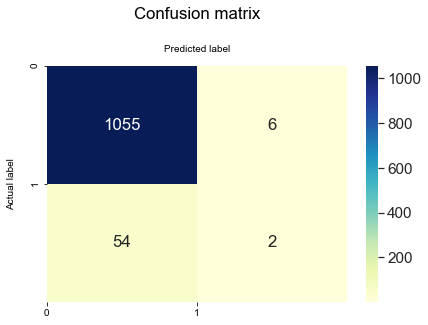

In [35]:
cm = confusion_matrix(y_test, y_pred) #Actual predicted
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))

plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g', cmap="YlGnBu" )

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()

plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

## 5. Feature Importance:

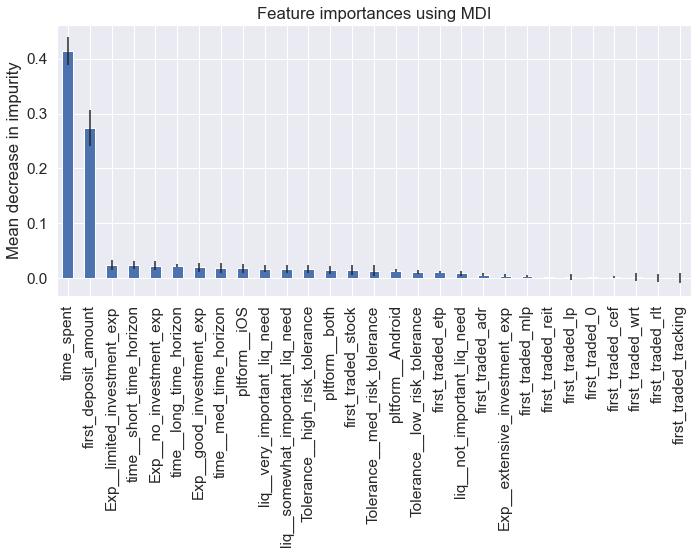

In [36]:
cols = [i for i in X.columns]
importances = RF_cl.feature_importances_

forest_importances = pd.Series(importances, index=cols).sort_values(ascending= False)

std = np.std([tree.feature_importances_ for tree in RF_cl.estimators_], axis=0)

fig, ax = plt.subplots(figsize = (10,8))

forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [37]:
forest_importances.head(3)

time_spent                     0.413725
first_deposit_amount           0.274372
Exp__limited_investment_exp    0.023776
dtype: float64

__Top 3 performing features:__
   1. Time_spent
   2. first_deposit_amount
   3. Exp__limited_investment_exp 

## 6. Conclusion:

1. Data is highly imbalanced.
2. Highly correlated categorical features to the Churn user are **risk_tolerance, platform, first_deposit_amount**.
3. Top 3 performing features are **Time_spent, first_deposit_amount, Exp__limited_investment_exp**.
4. Model gives **52%** classification accuracy across both the classes. Data is imbalanced and undersampling/ oversampling couldn't boost up the perfornce of the model.   
5. Precision of the model for class 0 and class 1 is **0.95, 0.25** respectively.
6. Recall of the model is **0.99 and 0.04** for class 0 and class 1 respectively.